In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Initialize wandb API
api = wandb.Api()

# Project configuration
project_name = "qwen3-reinforce-reasongym"
entity = None  # Set this to your wandb entity if needed

# Construct project path
project_path = f"{entity}/{project_name}" if entity else project_name

print(f"Loading runs from project: {project_path}")

# Get all runs from the project
runs = api.runs(project_path)

print(f"Found {len(runs)} total runs in the project")

# Filter for acre-related runs (based on the config patterns)
acre_runs = []
for run in runs:
    if run.name and ("acre" in run.name.lower()):
        acre_runs.append(run)

print(f"Found {len(acre_runs)} acre-related runs:")


Loading runs from project: qwen3-reinforce-reasongym
Found 192 total runs in the project
Found 150 acre-related runs:


In [2]:
# Find cutoff time from acre_shoggoth-36
cutoff_time = None
for run in acre_runs:
    if run.name == "acre_shoggoth-36 START":
        cutoff_time = run.created_at
        print(f"Cutoff time: {cutoff_time}")
        break

# Filter runs to only include those at or after cutoff
if cutoff_time:
    recent_acre_runs = [run for run in acre_runs if run.created_at >= cutoff_time]
else:
    print("No cutoff time found")
    recent_acre_runs = acre_runs

# Load detailed data for each recent acre run
run_data = []

for run in recent_acre_runs:
    
    # Get run configuration
    config = run.config
    
    # Get run summary (final metrics)
    summary = run.summary
    
    # Get run history (all logged metrics over time)
    history = run.history()
    
    # Store run information
    run_info = {
        'run': run,
        'name': run.name,
        'id': run.id,
        'state': run.state,
        'config': config,
        'summary': summary,
        'history': history
    }
    
    run_data.append(run_info)
    

print(f"\nLoaded data for {len(run_data)} acre runs")


Cutoff time: 2025-07-15T09:38:34Z



Loaded data for 31 acre runs


Created scatter plot data for 31 runs
Color distribution:
color
Split Model    12
Penalty        11
No Penalty      8
Name: count, dtype: int64


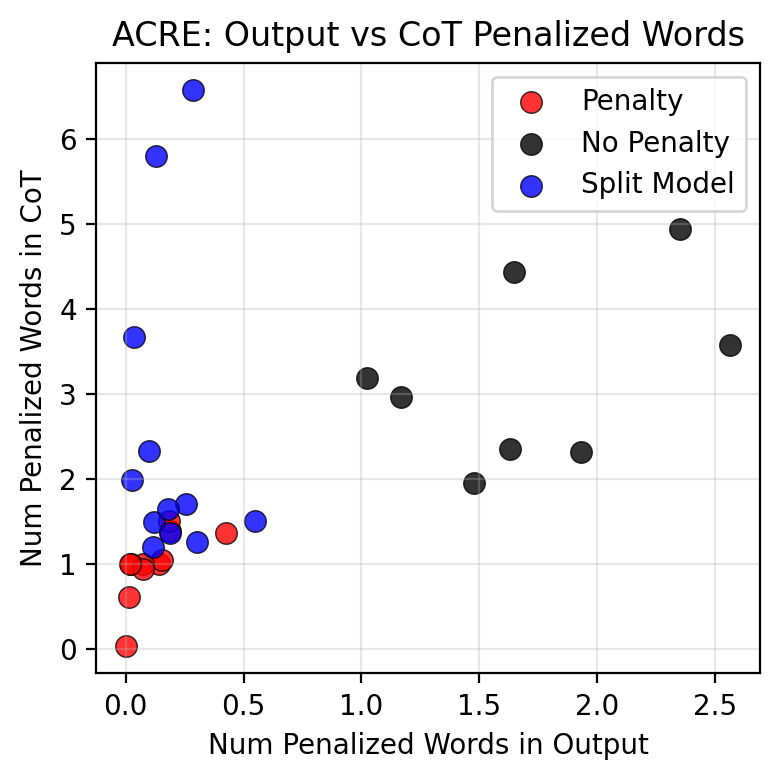

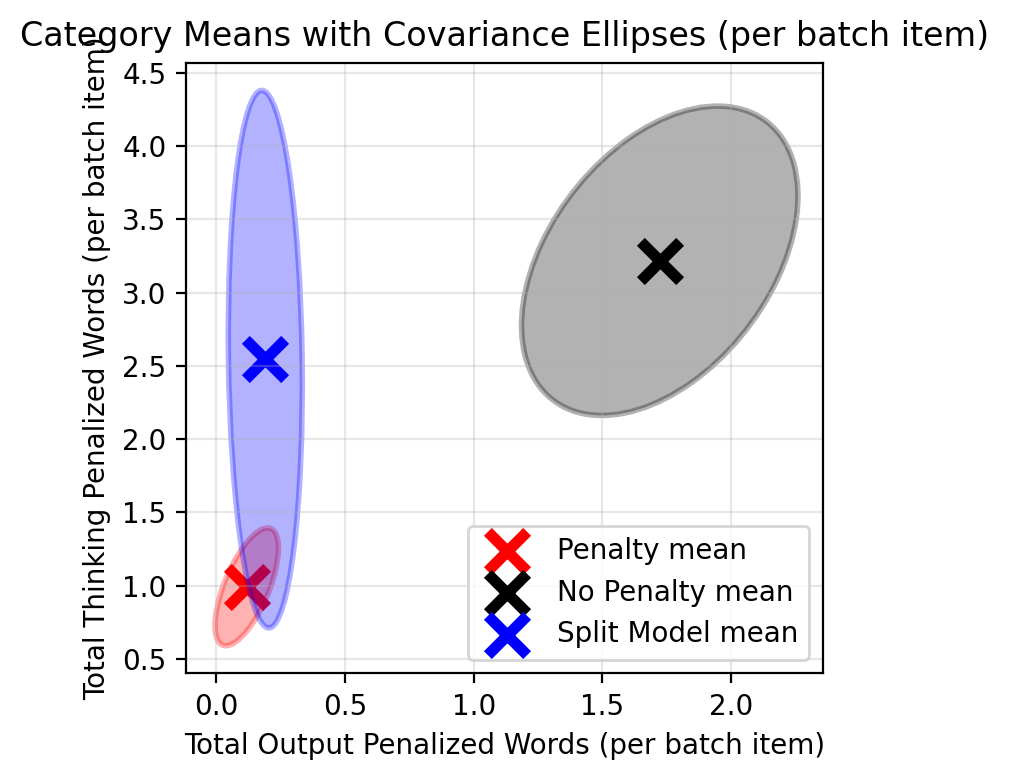


=== Scatter Plot Data Details ===
acre_shoggoth-36 START (Split Model, finished): output=0.12, thinking=1.50
acre_no_penalty-11 (No Penalty, finished): output=1.93, thinking=2.32
acre-63 (Penalty, finished): output=0.14, thinking=1.00
acre_shoggoth-37 (Split Model, finished): output=0.03, thinking=1.99
acre_no_penalty-12 (No Penalty, finished): output=1.48, thinking=1.95
acre-64 (Penalty, finished): output=0.15, thinking=1.05
acre_shoggoth-38 (Split Model, finished): output=0.03, thinking=3.67
acre_no_penalty-13 (No Penalty, finished): output=1.02, thinking=3.19
acre-65 (Penalty, finished): output=0.07, thinking=1.00
acre_no_penalty-14 (No Penalty, finished): output=1.17, thinking=2.96
acre_shoggoth-39 (Split Model, finished): output=0.10, thinking=2.33
acre-66 (Penalty, finished): output=0.19, thinking=1.39
acre_no_penalty-15 (No Penalty, finished): output=1.63, thinking=2.36
acre-67 (Penalty, finished): output=0.02, thinking=1.00
acre_no_penalty-16 (No Penalty, finished): output=2.3

In [3]:
# Scatter plot of total_output_penalized_words vs total_thinking_penalized_words
# Configuration
NUM_FINAL_STEPS = 10

# Factor to reduce image size and increase dpi
IMG_SIZE_REDUCE = 2  # Set this to your desired reduction factor

# Prepare data for scatter plot
scatter_data = []

for run_info in run_data:
    history = run_info['history']
    name = run_info['name']
    config = run_info['config']
    
    # Try to get batch size from config, fallback to 1 if not present
    batch_size = config.get('batch_size', 1)
    if batch_size == 0:
        batch_size = 1  # Avoid division by zero

    batch_size *= config['gradient_accumulation_steps']

    # Check if we have the required columns
    if 'total_output_penalized_words' in history.columns and 'total_thinking_penalized_words' in history.columns:
        # Get the last NUM_FINAL_STEPS, excluding the very last step
        if len(history) > NUM_FINAL_STEPS:
            # Take steps from -NUM_FINAL_STEPS-1 to -2 (excluding the very last step)
            final_steps = history.iloc[-(NUM_FINAL_STEPS+1):-1]
        else:
            # If we don't have enough steps, use all but the last step
            final_steps = history.iloc[:-1] if len(history) > 1 else history
        
        if len(final_steps) > 0:
            avg_output_words = final_steps['total_output_penalized_words'].mean() / batch_size
            avg_thinking_words = final_steps['total_thinking_penalized_words'].mean() / batch_size
            
            # Determine color based on run name
            if 'acre_shoggoth' in name.lower():
                color = 'Split Model'
            elif 'acre_no_penalty' in name.lower():
                color = 'No Penalty'
            else:
                color = 'Penalty'
            
            scatter_data.append({
                'name': name,
                'output_words': avg_output_words,
                'thinking_words': avg_thinking_words,
                'color': color,
                'state': run_info['state']
            })

# Convert to DataFrame for easier handling
scatter_df = pd.DataFrame(scatter_data)

print(f"Created scatter plot data for {len(scatter_df)} runs")
print(f"Color distribution:")
print(scatter_df['color'].value_counts())

# Define colors for each category
color_map = {
    'Penalty': 'red',
    'No Penalty': 'black', 
    'Split Model': 'blue',
}

# Adjust figure size and dpi
orig_figsize = (8, 8)
reduced_figsize = (orig_figsize[0] / IMG_SIZE_REDUCE, orig_figsize[1] / IMG_SIZE_REDUCE)
dpi = 100 * IMG_SIZE_REDUCE

# --- First plot: Scatter plot with all points ---
plt.figure(figsize=reduced_figsize, dpi=dpi)
for category in color_map.keys():
    category_data = scatter_df[scatter_df['color'] == category]
    if len(category_data) > 0:
        plt.scatter(
            category_data['output_words'], 
            category_data['thinking_words'],
            c=color_map[category],
            alpha=0.8,
            s=60,
            label=f'{category}',
            edgecolors='black',
            linewidth=0.5
        )

plt.xlabel('Num Penalized Words in Output')
plt.ylabel('Num Penalized Words in CoT')
plt.title('ACRE: Output vs CoT Penalized Words')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Second plot: Means with covariance ellipses ---
from matplotlib.patches import Ellipse

plt.figure(figsize=reduced_figsize, dpi=dpi)
for category in color_map.keys():
    category_data = scatter_df[scatter_df['color'] == category]
    if len(category_data) >= 2:  # Need at least 2 points for covariance
        # Calculate mean
        mean_x = category_data['output_words'].mean()
        mean_y = category_data['thinking_words'].mean()
        
        # Plot mean
        if category == 'shoggoth':
            mean_label = 'split model mean'
        else:
            mean_label = f'{category} mean'
        plt.scatter(mean_x, mean_y, c=color_map[category], s=200, 
                   marker='x', linewidth=4, label=mean_label)
        
        # Calculate covariance matrix
        data_points = category_data[['output_words', 'thinking_words']].values
        cov_matrix = np.cov(data_points.T)
        
        # Calculate eigenvalues and eigenvectors for ellipse
        eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
        
        # Calculate ellipse parameters (1 standard deviation)
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
        width = 2 * np.sqrt(eigenvals[0])
        height = 2 * np.sqrt(eigenvals[1])
        
        # Create ellipse
        ellipse = Ellipse((mean_x, mean_y), width, height, angle=angle,
                         facecolor=color_map[category], alpha=0.3,
                         edgecolor=color_map[category], linewidth=2)
        plt.gca().add_patch(ellipse)

plt.xlabel('Total Output Penalized Words (per batch item)')
plt.ylabel('Total Thinking Penalized Words (per batch item)')
plt.title('Category Means with Covariance Ellipses (per batch item)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed information about the runs
print(f"\n=== Scatter Plot Data Details ===")
for _, row in scatter_df.iterrows():
    print(f"{row['name']} ({row['color']}, {row['state']}): "
          f"output={row['output_words']:.2f}, thinking={row['thinking_words']:.2f}")

print(f"\n=== Summary Statistics by Category ===")
for category in color_map.keys():
    category_data = scatter_df[scatter_df['color'] == category]
    if len(category_data) > 0:
        print(f"\n{category.upper()}:")
        print(f"  Output words - mean: {category_data['output_words'].mean():.2f}, "
              f"std: {category_data['output_words'].std():.2f}")
        print(f"  Thinking words - mean: {category_data['thinking_words'].mean():.2f}, "
              f"std: {category_data['thinking_words'].std():.2f}")
        
        if len(category_data) >= 2:
            # Print covariance matrix
            data_points = category_data[['output_words', 'thinking_words']].values
            cov_matrix = np.cov(data_points.T)
            print(f"  Covariance matrix:")
            print(f"    [[{cov_matrix[0,0]:.2f}, {cov_matrix[0,1]:.2f}],")
            print(f"     [{cov_matrix[1,0]:.2f}, {cov_matrix[1,1]:.2f}]]")
